In [1]:

# import utils
import sys
sys.path.append('../../../utils')
import calibrate, simulate, misc

import simulate
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import simulate

In [21]:
class MultiHawkesProcessCalibrator:
    def __init__(self, events, d):
        self.events = events
        self.d = d

    def calibrate(self, initial_guess_flat, T):
        bounds = [(1e-10, None)] * self.d + [(1e-10, None)] * self.d**2 + [(1e-10, None)] * self.d**2
        res = minimize(fun=self.nll_d, args=(T, ), x0=initial_guess_flat, method='L-BFGS-B')
        return res.x
    
    def nll_2d(self, theta, T):
        mus = theta[:self.d]
        alphas = theta[self.d:self.d + self.d**2].reshape((self.d, self.d))
        betas = theta[self.d + self.d**2:].reshape((self.d, self.d))
        ll_1 = (1 - mus[0]) * T
        ll_2 = (1 - mus[1]) * T
        for k in range(len(self.events[0])):
            ll_1 = ll_1 - alphas[0, 0] / betas[0, 0] * (1 - np.exp(-betas[0, 0]*(T - self.events[0][k])))

    def nll_d(self, theta, T):
        # source: https://www.ism.ac.jp/editsec/aism/pdf/031_1_0145.pdf
        mus = theta[:self.d]
        alphas = theta[self.d:self.d + self.d**2].reshape((self.d, self.d))
        betas = theta[self.d + self.d**2:].reshape((self.d, self.d))
        n = np.max([len(self.events[i]) for i in range(self.d)])
        ll = np.zeros(self.d)
        for i in range(self.d):
            ll[i] = T - mus[i] * T
            for j in range(self.d):
                for k in range(len(self.events[i])):
                    ll[i] = ll[i] - alphas[i, j] / betas[i, j] * (1 - np.exp(-betas[i, j]*(T - self.events[i][k])))
        
        r_array = np.zeros((self.d, self.d, n))
        for i in range(self.d):
            for j in range(self.d):
                for k in range(1, len(self.events[i])):
                    if i==j:
                        r_array[i, j, k] = np.exp(-betas[i, j] * (self.events[i][k] - self.events[i][k - 1])) * (1 + r_array[i, j, k - 1])
                    else:
                        sum = 0
                        l = 0
                        while l < len(self.events[j]) and self.events[j][l] >= self.events[i][k - 1] and self.events[j][l] < self.events[i][k]:
                            sum += np.exp(-betas[i, j] * (self.events[i][k] - self.events[j][l]))
                            l += 1
                        r_array[i, j, k] = np.exp(-betas[i, j] * (self.events[i][k] - self.events[i][k - 1])) * (1 + r_array[i, j, k - 1]) + sum

        for i in range(self.d):
            for j in range(self.d):
                for k in range(len(self.events[i])):
                    ll[i] += np.log(mus[i] + alphas[i, j]*r_array[i, j, k])  
                    # r_ijk = 0
                    # l = 0
                    # while l < len(events[j]) and events[j][l] < events[i][k]:
                    #     r_ijk += np.exp(-betas[i, j] * (events[i][k] - events[j][l]))
                    #     l += 1
                    # ll[i] = ll[i] + np.log(mus[i] + alphas[i, j]*r_ijk) 

        return -np.sum(ll)

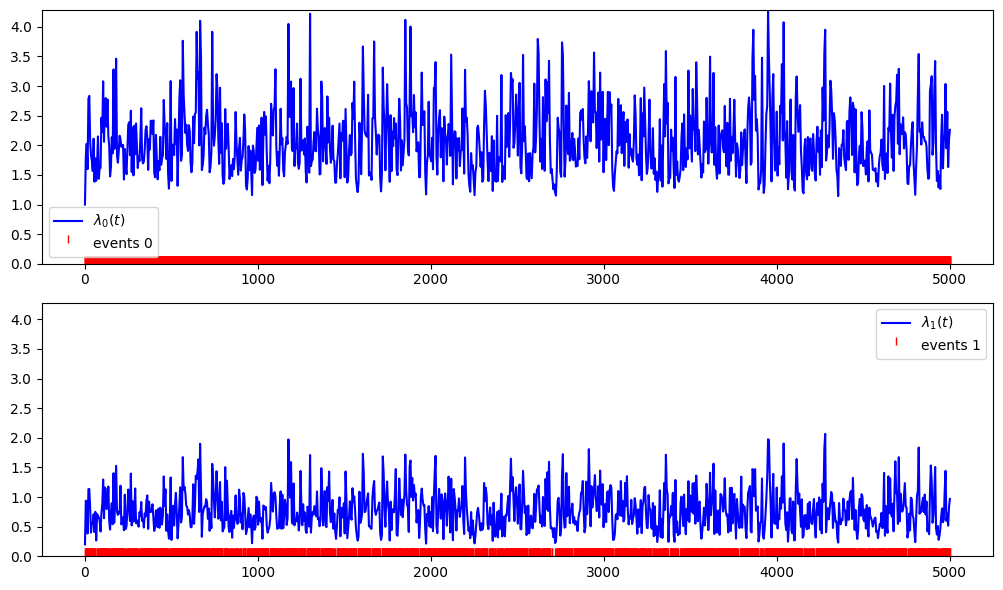

In [16]:
d = 2

mus = [1, 0.2]
alphas = [[0.1, 0.5], [0.2, 0.1]]
betas = [[0.3, 1], [1, 0.5]]

hawkes = simulate.MultiHawkesProcess(mus, alphas, betas)
T = 5000
events = hawkes.simulate(T)
hawkes.plot(events, T)

In [22]:
cal_2D = MultiHawkesProcessCalibrator(events, d)

mus = [1.2, 0.4]
alphas = [[0.1, 0.6], [0.3, 0.1]]
betas = [[0.3, 1.3], [1.5, 0.5]]

initial_guess_flat = np.concatenate([np.array(mus).flatten(), np.array(alphas).flatten(), np.array(betas).flatten()])

ll = cal_2D.nll_d(initial_guess_flat, T)
theta = cal_2D.calibrate(initial_guess_flat, T)

mus = theta[:d]
alphas = theta[d:d + d**2].reshape((d, d))
betas = theta[d + d**2:].reshape((d, d))

print("Calibrated mus: ", mus)
print("True mus: ", hawkes.mus, "\n")

print("Calibrated alphas: ", alphas)
print("True alphas: ", hawkes.alphas, "\n")

print("Calibrated betas: ", betas)
print("True betas: ", hawkes.betas)

C:\Users\gecre\AppData\Local\Temp\ipykernel_26064\1022207097.py:50: RuntimeWarning: invalid value encountered in log
  ll[i] += np.log(mus[i] + alphas[i, j]*r_array[i, j, k])
C:\Users\gecre\AppData\Local\Temp\ipykernel_26064\1022207097.py:31: RuntimeWarning: overflow encountered in exp
  ll[i] = ll[i] - alphas[i, j] / betas[i, j] * (1 - np.exp(-betas[i, j]*(T - self.events[i][k])))
C:\Users\gecre\AppData\Local\Temp\ipykernel_26064\1022207097.py:31: RuntimeWarning: overflow encountered in scalar multiply
  ll[i] = ll[i] - alphas[i, j] / betas[i, j] * (1 - np.exp(-betas[i, j]*(T - self.events[i][k])))
C:\Users\gecre\AppData\Local\Temp\ipykernel_26064\1022207097.py:38: RuntimeWarning: overflow encountered in scalar multiply
  r_array[i, j, k] = np.exp(-betas[i, j] * (self.events[i][k] - self.events[i][k - 1])) * (1 + r_array[i, j, k - 1])
C:\Users\gecre\AppData\Local\Temp\ipykernel_26064\1022207097.py:50: RuntimeWarning: overflow encountered in scalar multiply
  ll[i] += np.log(mus[i] + a

KeyboardInterrupt: 

In [18]:
print("log-likelihood of true parameters: ", -cal_2D.nll_d(np.concatenate([np.array(hawkes.mus).flatten(), np.array(hawkes.alphas).flatten(), np.array(hawkes.betas).flatten()]), T))
print("log-likelihood of calibrated parameters: ", -cal_2D.nll_d(theta, T))

log-likelihood of true parameters:  -753.8929847841518
log-likelihood of calibrated parameters:  14493.905378148043
